In [1]:
from remote_vgk import *
from buffet import (
    buffet_classification
)

import numpy as np
import matplotlib.pyplot as plt

def load_password(path):

    with open(path) as f:
        secrets = json.load(f)
        shifted_pwd = secrets['password']
    pwd = ''
    for s in shifted_pwd:
        pwd += chr(ord(s) - 1)

    return pwd

In [2]:
try:
    window = gw.getWindowsWithTitle("millenicut")[0]
except IndexError:
    raise Exception("Window not found")

pwd = load_password('secrets.json')
sesh = DPO_Session('lwp26', pwd)

App = AirfoilApp(sesh.teaching_client, window, "2.3_incidence_aerofoil")

# IMPORTANT SET THE SAME PARAMETERS AS ON THE APP
App.alpha = 1.75
App.M = 0.76
App.Re = 10

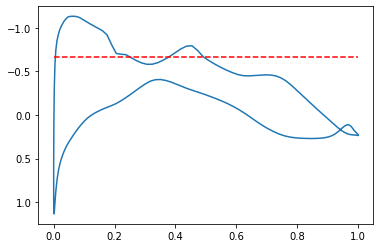

In [3]:
from buffet import cpstar_from_mach

M = 0.73
res = App.run(M, 2, 10)
plt.plot(res.x, res.cp)

plt.hlines(cpstar_from_mach(M), 0, 1, 'r', '--')

# flip y axis
plt.gca().invert_yaxis()


In [4]:
print(res.Cl, res.Cd, res.CD2)

0.53492 0.00853 0.0003199999999999991


In [6]:

App.classify_buffeting()


C:\Users\louis\AppData\Local\Temp\ipykernel_13940\3142525549.py:54: UserWarning: No contour levels were found within the data range.
  ax.contour(x_grid, y_grid, z_grid_smoothed, levels=[0], colors='black', linewidths=1, zorder = 20)


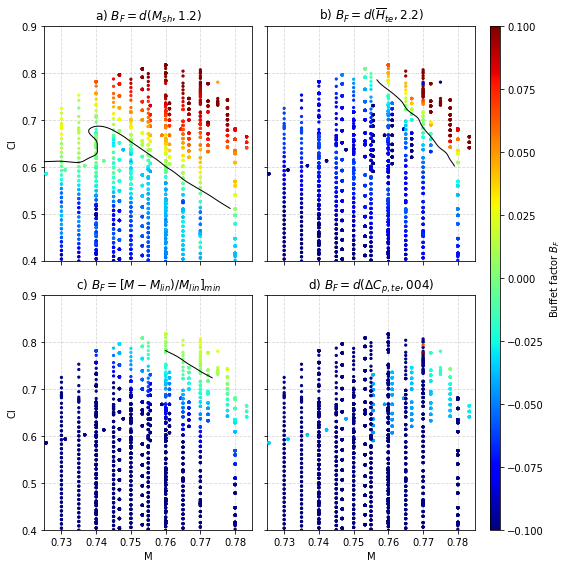

In [7]:
from matplotlib import gridspec
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

# scatter plot
buffet_types = [
    'a) $B_F = d(M_{sh}, 1.2)$',
    'b) $B_F = d(\overline{H}_{te}, 2.2)$',
    'c) $B_F = [M - M_{lin})/M_{lin}]_{min}$',
    'd) $B_F = d(\Delta C_{p,te}, 004)$'
]

fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 0.05])
# Create subplots with shared axes
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1, sharey=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax1)
colax = fig.add_subplot(gs[:2, 2:])  # For the colorbar

axes = [ax1, ax2, ax3, ax4]

for nt,type in enumerate(buffet_types):

    ax = axes[nt]

    Cl_list = []
    M_list = []
    alpha_list = []

    for res in App:

        Cl_list.append(res.Cl)
        M_list.append(res.M)
        alpha_list.append(res.alpha)

    buffeting_list = np.nan*np.ones(len(Cl_list))
    i = 0
    for res in App:
        if len(res.buffet_causes) > 0:
            buffeting_list[i] = res.buffet_causes[nt]
        i += 1

    x_grid, y_grid = np.meshgrid(
        np.linspace(np.min(M_list), np.max(M_list), 200),
        np.linspace(np.min(Cl_list), np.max(Cl_list), 200)
        )

    z_grid = griddata((M_list, Cl_list), buffeting_list, (x_grid, y_grid), method='linear')
    z_grid_smoothed = gaussian_filter(z_grid, sigma=2) 

    scat = ax.scatter(M_list, Cl_list, c=buffeting_list, s = 5, cmap='jet', vmin=-0.1, vmax=0.1, zorder = 10)
    ax.contour(x_grid, y_grid, z_grid_smoothed, levels=[0], colors='black', linewidths=1, zorder = 20)
    ax.set_xlim(0.725, 0.785)
    ax.set_ylim(0.4, 0.9)
    # create colourbar
    ax.grid( linestyle='--', alpha=0.5, zorder=1)
    ax.set_title(f'{type}')

for ax in [ax2, ax4]:  # Hide y-axis labels for the right column
    ax.tick_params(labelleft=False)
for ax in [ax1, ax2]:  # Hide x-axis labels for the bottom row
    ax.tick_params(labelbottom=False)

for ax in [ax1, ax3]:
    ax.set_ylabel("Cl")
for ax in [ax3, ax4]:
    ax.set_xlabel("M")
    ax.set_xticks(np.arange(0.73, 0.78, 0.01))

cbar = fig.colorbar(scat, cax=colax, orientation='vertical')
cbar.set_label("Buffet factor $B_F$")

plt.tight_layout()
plt.savefig('figures/buffet_classification.png', dpi = 400)
plt.show()